In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils.image import resplit
import os

In [2]:
original_path = ['.', 'data', 'new_data']
new_path = ['.', 'data', 'segmentated_data']

### Use rectangle image (size 150 x 50) instead of square image

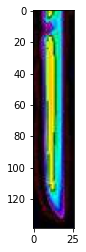

In [15]:
path = './data/segmentated_data/OK'
imgpath = os.listdir(path)[0]
img = plt.imread(os.path.join(path, imgpath))
plt.imshow(img)

In [16]:
import os
import numpy as np
import tensorflow as tf
from datetime import datetime, date
from utils.model import create_model
from utils.webservice import getsize_h5model, log_write
from utils.data import create_dataframe, ImageGenerator, get_sample, config_batch
from sklearn.model_selection import train_test_split

from configs.server import MODEL_PATH, LOG_FILE, FLAG, HIST, NEED_CONFIRM
from configs.image import DATA_PATH
import keras
import matplotlib.pyplot as plt

In [17]:
image_folder = 'segmentated_data'
training_path = os.path.join(DATA_PATH, image_folder)
classes = [name for name in os.listdir(training_path)
               if os.path.isdir(os.path.join(training_path, name))]
num_classes = len(classes)
image_shape = (150, 50, 3)

In [18]:
image_dataframe = create_dataframe(training_path, classes)
image_dataframe.head(4)

,Filepath,Classes,Label
0,data\segmentated_data\NG\left_20191125091739_W...,NG,0
1,data\segmentated_data\NG\left_20191125091923_W...,NG,0
2,data\segmentated_data\NG\left_20191125092017_W...,NG,0
3,data\segmentated_data\NG\left_20191125092137_W...,NG,0


In [19]:
data_split = ['train', 'val']

In [20]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_frame, test_frame = train_test_split(image_dataframe, test_size=0.15, random_state=911)
dtframe = {'train': train_frame, 'val': test_frame}

generator = {x: image_generator.flow_from_dataframe(dataframe=dtframe[x], 
                                                    x_col='Filepath',
                                                    y_col='Classes',
                                                    target_size=(150, 50),
                                                    class_model='categorical',
                                                    shuffle = x == 'train',
                                                    batch_size=8)
            for x in data_split}

Found 589 validated image filenames belonging to 2 classes.
Found 105 validated image filenames belonging to 2 classes.


In [21]:
imgs, _ = next(generator['val'])

In [22]:
imgs.shape

(8, 150, 50, 3)

In [23]:
lr = 0.001
def scheduler(epoch):
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(0.1 * (10 - epoch))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [24]:
checkpoint_path = './tflog/simple_segmentated.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
saving_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  monitor='val_accuracy',
                                                  save_best_only=True,
                                                  verbose=1)

In [25]:
model = create_model(model_name='Simple', 
                     n_outs=num_classes,
                     input_shape=image_shape,
                     learning_rate=lr,
                     pre_train=False)
history = model.fit(x=generator['train'],
                    validation_data=generator['val'],
                    validation_freq=1,
                    epochs=50,
                    verbose=1, 
                    callbacks=[lr_callback, saving_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 74 steps, validate for 14 steps
Epoch 1/50
73/74 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8554
Epoch 00001: val_accuracy improved from -inf to 0.19048, saving model to ./tflog/simple_segmentated.h5
74/74 [==============================] - 4s 57ms/step - loss: 0.3105 - accuracy: 0.8574 - val_loss: 1.1123 - val_accuracy: 0.1905
Epoch 2/50
73/74 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.8692
Epoch 00002: val_accuracy did not improve from 0.19048
74/74 [==============================] - 2s 26ms/step - loss: 0.2618 - accuracy: 0.8710 - val_loss: 1.0384 - val_accuracy: 0.1905
Epoch 3/50
72/74 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.8953
Epoch 00003: val_accuracy did not improve from 0.19048
74/74 [==============================] - 2s 26ms/step - loss: 0.2033 - accuracy: 0.8981 - val_loss: 1.2154 - val_accuracy: 0.1905
Epoch 4/50
72/74 [=====

Epoch 28/50
72/74 [============================>.] - ETA: 0s - loss: 8.5434e-04 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.96190
74/74 [==============================] - 2s 26ms/step - loss: 8.5389e-04 - accuracy: 1.0000 - val_loss: 0.2704 - val_accuracy: 0.9524
Epoch 29/50
72/74 [============================>.] - ETA: 0s - loss: 7.9911e-04 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.96190
74/74 [==============================] - 2s 26ms/step - loss: 8.1076e-04 - accuracy: 1.0000 - val_loss: 0.2691 - val_accuracy: 0.9524
Epoch 30/50
73/74 [============================>.] - ETA: 0s - loss: 7.6875e-04 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.96190
74/74 [==============================] - 2s 26ms/step - loss: 7.7623e-04 - accuracy: 1.0000 - val_loss: 0.2716 - val_accuracy: 0.9524
Epoch 31/50
72/74 [============================>.] - ETA: 0s - loss: 7.5167e-04 - accuracy: 1.0000 ETA: 1s -
Epoch 00031: val_accuracy d

In [26]:
model = tf.keras.models.load_model('./tflog/simple_segmentated.h5')

In [27]:
model.evaluate(generator['val'])

  ...
    to  
  ['...']
14/14 [==============================] - 0s 16ms/step - loss: 0.2611 - accuracy: 0.9619


[0.26108564548667346, 0.96190476]

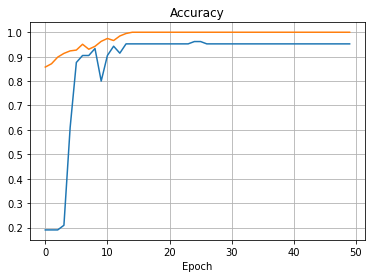

In [28]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid()

Text(0.5, 0, 'Epoch')

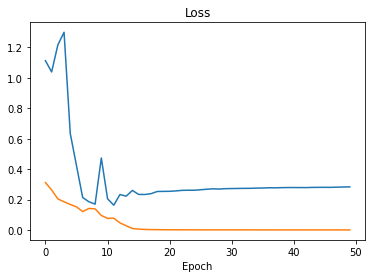

In [29]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')

### Comparison

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
true = test_frame['Label'].values.astype('int64')
pred = np.argmax(model.predict(generator['val']), axis=1)

# old_true = old_test_frame['Label'].values.astype('int64')
# old_pred = np.argmax(old_model.predict(old_generator['val']), axis=1)

In [32]:
confusion_matrix(y_true=true, y_pred=pred)

array([[19,  1],
       [ 3, 82]], dtype=int64)

In [21]:
confusion_matrix(y_true=old_true, y_pred=old_pred)

array([[ 2,  0,  0,  0],
       [ 0,  3,  1,  2],
       [ 0,  0, 41,  0],
       [ 0,  0,  0,  4]], dtype=int64)